In [1]:
# imports
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc

In [2]:
# load the data
data = pd.read_csv('data.csv')
data.head()

,statename,year,month,spend apparel and accessories,spend accommodation and food services,"spend arts, entertainment, and recreation",spend all,spend general merchandise + apparel,spend durable goods,spend general merchandise,...,hospitalized_rate,day,time retail and recreation,time grocery and pharmacy,time parks,time transit stations,time workplaces,time residential,time away from home,emp recovered
0,Alabama,2020,1,0.0000,-1.910000e-09,0.0000,0.0000,-2.880000e-08,3.280000e-08,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,Alabama,2020,2,-0.0438,2.160000e-02,0.0643,0.0278,2.020000e-02,1.250000e-02,0.0782,...,NaN,29.0,0.0900,0.0414,0.191,0.1070,0.010,-0.00571,0.00855,True
2,Alabama,2020,3,-0.3510,-3.800000e-01,-0.3730,-0.0898,-1.460000e-01,-3.850000e-02,0.0646,...,0.101591,31.0,-0.3340,-0.0643,0.180,-0.2340,-0.344,0.13100,-0.15900,False
3,Alabama,2020,4,-0.5350,-6.060000e-01,-0.6520,-0.2290,-3.190000e-01,1.530000e-02,-0.0916,...,7.704000,30.0,-0.2400,-0.0300,0.143,-0.2300,-0.347,0.12100,-0.14800,False
4,Alabama,2020,5,-0.1820,-3.820000e-01,-0.4720,-0.1010,-7.270000e-02,1.720000e-01,0.0279,...,8.569677,31.0,-0.0914,0.0314,0.373,-0.0371,-0.236,0.08290,-0.09430,False


In [3]:
data.columns

Index(['statename', 'year', 'month', 'spend apparel and accessories',
       'spend accommodation and food services',
       'spend arts, entertainment, and recreation', 'spend all',
       'spend general merchandise + apparel', 'spend durable goods',
       'spend general merchandise', 'spend grocery and food stores',
       'spend health care and social assistance',
       'spend home improvement centers', 'spend other in-person services',
       'spend non-durable goods', 'spend remote services',
       'spend transportation and warehousing', 'spend all_incmiddle',
       'spend all q1', 'spend all q2', 'spend all q3', 'spend all q4',
       'spend in-person services', 'spend retail excluding grocery',
       'spend retail including grocery', 'day_endofweek', 'emp all', 'emp q1',
       'emp q2', 'emp q3', 'emp q4', 'emp inc middle', 'emp inc below_median',
       'emp inc above median', 'emp trade_transport utilities',
       'emp professional business_services', 'emp education hea

### 1. data prep

In [25]:
# select features and target
feat = ['spend all', 'spend arts, entertainment, and recreation', # spend features
        'case_rate', 'death_rate', 'hospitalized_rate', # covid features, 
        ]
target = 'emp recovered'

# see missing values in features and target
print(f'num missing in cols: \n{data[feat + [target]].isnull().sum()}')

# drop rows with missing values
data = data.dropna(subset=feat + [target])

# store statenames for mapping later
state_names = data['statename']

# define X and y
X = data[feat]
y = data[target].astype(int)

X.head()


num missing in cols: 
spend all                                    0
spend arts, entertainment, and recreation    0
case_rate                                    0
death_rate                                   0
hospitalized_rate                            0
emp recovered                                0
dtype: int64


,spend all,"spend arts, entertainment, and recreation",case_rate,death_rate,hospitalized_rate
2,-0.08980,-0.373,3.848895,0.017158,0.101591
3,-0.22900,-0.652,72.970000,2.257533,7.704000
4,-0.10100,-0.472,224.387097,8.786129,8.569677
5,-0.02560,-0.302,504.966667,15.463333,16.526667
6,0.00473,-0.326,1166.548387,24.080645,32.906452


### 2. define train and test sets

In [26]:
# test set is all data from january 2025 (five years after the start of the pandemic)
test_mask = (data['year'] == 2025) & (data['month'] == 1)
X_test = X[test_mask]
y_test = y[test_mask]
states_test = state_names[test_mask]

# train set is all other data
X_train = X[~test_mask]
y_train = y[~test_mask]
states_train = state_names[~test_mask]

# print lengths of train and test sets
print(f'train set length: {len(X_train)}')
print(f'test set length: {len(X_test)}')

train set length: 3133
test set length: 50


### 3. initialize and fit the random forest model

In [22]:
# initialize the model
rfc = RandomForestClassifier(n_estimators=100, random_state=8)

# fit the model
rfc.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### 4. make predictions

In [7]:
# use fitted model to make predictions
y_pred = rfc.predict(X_test)

# map state to results
results = pd.DataFrame({
    'statename': states_test.values,
    'actual': y_test.values,
    'predicted': y_pred
})

results.head()

,statename,actual,predicted
0,Alabama,0,0
1,Alaska,1,1
2,Arizona,0,0
3,Arkansas,0,0
4,California,0,0


### 5. evaluate model

In [8]:
# baseline rate
baseline_acc = max(y_test.mean(), 1 - y_test.mean())
print("baseline accuracy:", baseline_acc)

# model performance
print("model accuracy:", accuracy_score(y_test, y_pred))
print("\nclassification report:\n", classification_report(y_test, y_pred))
print("\nconfusion matrix:\n", confusion_matrix(y_test, y_pred))


baseline accuracy: 0.7
model accuracy: 0.98

classification report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99        35
           1       0.94      1.00      0.97        15

    accuracy                           0.98        50
   macro avg       0.97      0.99      0.98        50
weighted avg       0.98      0.98      0.98        50


confusion matrix:
 [[34  1]
 [ 0 15]]


In [9]:
importances = rfc.feature_importances_
for name, importance in zip(feat, importances):
    print(f"{name}: {importance:.4f}")


spend all: 0.1672
spend arts, entertainment, and recreation: 0.1702
case_rate: 0.2990
death_rate: 0.2069
hospitalized_rate: 0.1567


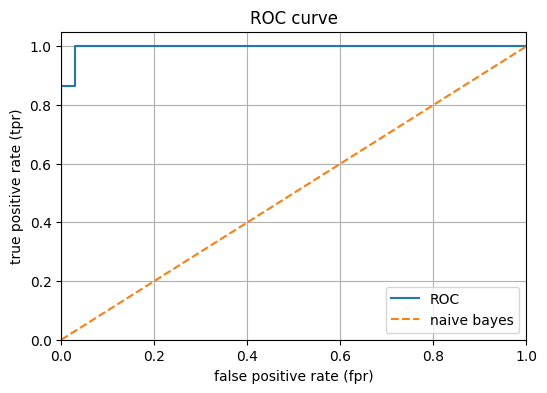

In [23]:
# plot roc and auc
y_prob = rfc.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC')
plt.plot([0, 1], [0, 1], linestyle='--', label='naive bayes')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('false positive rate (fpr)')
plt.ylabel('true positive rate (tpr)')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [11]:
# plot state results (red for incorrect)
plt.figure(figsize=(10, 6))
state_abbrev = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT',
    'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN',
    'Iowa': 'IA', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA',
    'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
    'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND',
    'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD',
    'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV',
    'Wisconsin': 'WI', 'Wyoming': 'WY', 'District of Columbia': 'DC'
}

# map states to abbreviations 
results['state_abbrev'] = results['statename'].map(state_abbrev)

# make a new col for prediction results
results['prediction'] = np.where((results['predicted'] == 1) & (results['actual'] == 1), 'TP', #TP
                        np.where((results['predicted'] == 0) & (results['actual'] == 0), 'TN', #TN
                        np.where((results['predicted'] == 1) & (results['actual'] == 0), 'FP', 'FN'))) #FP, FN

# plot choropleth map
fig = px.choropleth(
    results,
    locations='state_abbrev',
    locationmode='USA-states',
    color='prediction',
    color_discrete_map={'TP': '#96b9d0', 'TN': '#ffd5b6', 'FP': '#fad4d5', 'FN': '#fad4d5'},
    scope='usa',
    title='COVID-19 Employment Recovery Prediction Results (Jan 2025)',
    width=1000,
    height=600,
)

fig.show()


<Figure size 1000x600 with 0 Axes>

### variant 1: change the number of trees (n_estimators) → see how model stability and accuracy is affected

In [24]:
# number of estimators to test
n = [25, 50, 75, 125, 150]

print(f'original model: n_estimators = 100 | accuracy: {accuracy_score(y_test, y_pred):.4f}')

# fit models for each n
for estimators in n:
    rfc = RandomForestClassifier(n_estimators=estimators, random_state=8)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    print(f"n_estimators: {estimators} | accuracy: {accuracy_score(y_test, y_pred):.4f}")

original model: n_estimators = 100 | accuracy: 0.9800
n_estimators: 25 | accuracy: 0.9800
n_estimators: 50 | accuracy: 0.9800
n_estimators: 75 | accuracy: 0.9800
n_estimators: 125 | accuracy: 0.9800
n_estimators: 150 | accuracy: 0.9800
